# 01 - Framework

## Set up

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import scipy as sp
import pandas as pd

import warnings
#import tqdm

#import pandas_datareader.data as web
#import datetime as dt

#import statsmodels.api as sm
#import linearmodels as lm
#import arch as am

import matplotlib.pyplot as plt
import seaborn as sns

import sys
sys.path.append('../')
sys.path.append('../../kungfu/')
sys.path.append('../../yetagain/')

import src
import kungfu as kf
import yetagain as ya

#sys.path.append('../../kungfu/')
#import kungfu as kf

In [3]:
pd.set_option('display.float_format', lambda x: '%.4f' % x) #sets decimals to be displayed

In [4]:
sns.set()
sns.set(rc={'figure.figsize': (17, 6)})

In [5]:
%matplotlib inline

In [7]:
#from src.models import NormalModel
#from src.hmm import HMM
#import src

## Load data

In [6]:
df_predictors = pd.read_pickle('../data/external/df_predictors.pkl')
s_dp = df_predictors.dp.asfreq('M')
s_ret = df_predictors['Index'].pct_change().asfreq('M')

In [7]:
s_daily = pd.read_pickle('../data/external/market_daily.pkl').set_obstype('return')
s_monthly = pd.read_pickle('../data/external/market_monthly.pkl').set_obstype('return')

In [8]:
series = s_dp.dropna()

In [9]:
series = s_ret.dropna()

In [10]:
series = s_daily

In [11]:
series = s_monthly

## Compare densities

In [12]:
from sklearn.mixture import GaussianMixture

In [13]:
def fit_gaussian_mixture_distribution(data, K=1):
    
    '''
    MOVE
    '''
    
    # Gaussian mixture model
    gmm = GaussianMixture(n_components=K).fit(data.values.reshape(-1,1))
    
    # Obtain mixture distribution
    mix = src.MixtureDistribution([])
    for (m,s,p) in zip(gmm.means_.flatten(),gmm.covariances_.flatten()**0.5,gmm.weights_):
        mix.add_component(distribution=src.NormalDistribution(mu=m, sigma=s), weight=p)
        
    return mix

def fit_kernel_density_distrbution(data, method='scott'):
    
    '''
    
    '''
    
    # equal weights
    w = 1/data.count()
    
    # scale parameter
    if method == 'scott':
        s = 3.5*data.std()/(data.count()**(1/3))
    if method == 'silverman':
        s = ((4*data.std()**5)/(3*data.count()))**(1/5)
    
    # create mixture
    kde = src.MixtureDistribution(components=[(src.NormalDistribution(mu=m, sigma=s), w) for m in data])
#     kde = GaussianMixtureDistribution([(m,s,w) for m in data])
    return kde

def fit_normal_distribution(data):
    normal = src.NormalDistribution(mu=data.mean(), sigma=data.std())
#     normal = sp.stats.norm(data.mean(),data.std())
    return normal

In [14]:
kde = fit_kernel_density_distrbution(series, method='silverman')
mix2 = fit_gaussian_mixture_distribution(series, K=2)
mix3 = fit_gaussian_mixture_distribution(series, K=3)
mix4 = fit_gaussian_mixture_distribution(series, K=4)
mix5 = fit_gaussian_mixture_distribution(series, K=5)
mix8 = fit_gaussian_mixture_distribution(series, K=8)
mix16 = fit_gaussian_mixture_distribution(series, K=16)
mix32 = fit_gaussian_mixture_distribution(series, K=32)
mix64 = fit_gaussian_mixture_distribution(series, K=64)
normal = fit_normal_distribution(series)

normal2 = fit_gaussian_mixture_distribution(series, K=1)

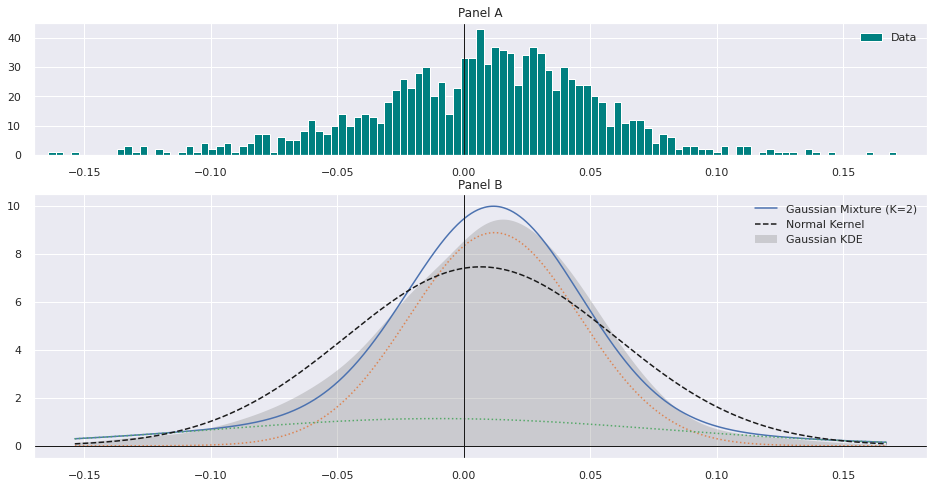

In [15]:
# plot
from src.plots import plot_mixture_components, plot_kernel_density, plot_pdf

#mix = hmm.get_mixture_distribution(state='steady_state')

fig, axes = plt.subplots(2, 1, figsize=[16,8], gridspec_kw={'height_ratios': [1, 2]})

ax = axes[1]
plot_pdf(mix2, ax=ax, label='Gaussian Mixture (K=2)')
plot_mixture_components(mix2, ax=ax)
plot_kernel_density(series, ax=ax, label='Gaussian KDE', color='grey')
plot_pdf(normal, ax=ax, linestyle='--', color='k', label='Normal Kernel')
ax.axhline(0, color='k', linewidth=1)
ax.axvline(0, color='k', linewidth=1)
ax.set_title('Panel B')
ax.legend()

lim = ax.get_xlim()
ax = axes[0]
ax.set_xlim(lim)
ax.hist(series,bins=series.count()//5, color='teal', label='Data')
ax.axvline(0, color='k', linewidth=1)
ax.set_title('Panel A')
ax.legend()

# fig.savefig('../latex/figures/distribution_comparison.pdf', format='pdf', dpi=200, bbox_inches='tight')

plt.show()

In [16]:
def kolmogorov_smirnov_test(data, distribution):
    test_statistic = sp.stats.kstest(data, distribution.cdf)[0]
    return test_statistic

def kuipers_test(data, distribution):
    test_statistic = sp.stats.kstest(data, distribution.cdf, alternative='less')[0]\
                        + sp.stats.kstest(data, distribution.cdf, alternative='greater')[0]
    return test_statistic

def distribution_log_likelihood(data, distribution):
    log_likelihood = np.log(distribution.pdf(data)).sum()
    return log_likelihood

In [17]:
def data_stats(data):
    values = [data.mean(),
              data.std(),
              data.skew(),
              data.kurt()-3,
              np.nan,
              np.nan,
             np.nan]
    return values

def comparison_stats(data, distribution):
    values = [distribution.mean(),
              distribution.std(),
              distribution.skew(),
              distribution.exkurt(),
              kolmogorov_smirnov_test(data, distribution),
              kuipers_test(data, distribution),
              distribution_log_likelihood(data, distribution)]
    return values

In [18]:
comparison_table = kf.FinancialDataFrame(columns=['mean','std','skew','exkurt','Kolmogorov-Smirnov','Kuiper\'s test','log-likelihood'])

comparison_table.loc['Data'] = data_stats(series)
comparison_table.loc['Gaussian KDE'] = comparison_stats(series, kde)
comparison_table.loc['Normal Distribution (K=1)'] = comparison_stats(series, normal)
comparison_table.loc['Gaussian Mixture (K=2)'] = comparison_stats(series, mix2)
comparison_table.loc['Gaussian Mixture (K=3)'] = comparison_stats(series, mix3)
comparison_table.loc['Gaussian Mixture (K=4)'] = comparison_stats(series, mix4)
comparison_table.loc['Gaussian Mixture (K=5)'] = comparison_stats(series, mix5)
comparison_table.loc['Gaussian Mixture (K=8)'] = comparison_stats(series, mix8)
comparison_table.loc['Gaussian Mixture (K=16)'] = comparison_stats(series, mix16)
comparison_table.loc['Gaussian Mixture (K=32)'] = comparison_stats(series, mix32)
comparison_table.loc['Gaussian Mixture (K=64)'] = comparison_stats(series, mix64)

comparison_table = comparison_table.replace(np.nan,'')\
                                   .replace(0,'')

#comparison_table.export_to_latex(path='../latex/tables/', filename='distribution_comparison')

comparison_table

,mean,std,skew,exkurt,Kolmogorov-Smirnov,Kuiper's test,log-likelihood
Data,0.0066,0.0535,0.1687,4.6970,,,
Gaussian KDE,0.0066,0.0552,0.1528,6.7196,0.0222,0.0439,1835.9893
Normal Distribution (K=1),0.0066,0.0535,,,0.0655,0.1297,1703.3345
Gaussian Mixture (K=2),0.0066,0.0535,-0.5327,3.1620,0.0189,0.0363,1811.2924
Gaussian Mixture (K=3),0.0066,0.0535,-0.3894,4.2760,0.0174,0.0346,1822.4158
Gaussian Mixture (K=4),0.0066,0.0535,0.0690,6.6699,0.0215,0.0334,1824.5793
Gaussian Mixture (K=5),0.0066,0.0535,0.1384,6.5799,0.0147,0.0291,1822.6605
Gaussian Mixture (K=8),0.0066,0.0535,0.1789,7.9260,0.0144,0.0243,1834.0824
Gaussian Mixture (K=16),0.0066,0.0535,0.1693,7.6369,0.0070,0.0139,1844.5285
Gaussian Mixture (K=32),0.0066,0.0535,0.1684,7.6526,0.0066,0.0121,1870.2296


## Forecast Plots

### Set up model

In [19]:
emission_models = (ya.NormalModel(mu=1.1, sigma=0.2), ya.NormalModel(mu=1-0.2, sigma=0.3))
transition_matrix = np.matrix([[0.99, 0.01],
                               [0.05, 0.95]])
state_vector = [0.7, 0.3]
hmm = ya.HiddenMarkovModel(emission_models=emission_models, transition_matrix=transition_matrix, state_vector=state_vector)

In [20]:
mu_0 = -0.001088091030590657
mu_1 = 0.0007135045295192978
sigma2_0 = 0.00035580049937316557
sigma2_1 = 3.712493137298489e-05
sigma_0 = sigma2_0**0.5
sigma_1 = sigma2_1**0.5
emission_models = (ya.NormalModel(mu=mu_0+1, sigma=sigma_0), ya.NormalModel(mu=mu_1+1, sigma=sigma_1))

p00 = 0.9578343472909316
p10 = 0.013033813102422378
transition_matrix = [[p00, 1-p00],
                     [p10, 1-p10]]

state_vector = [0.7, 0.3]
hmm = ya.HiddenMarkovModel(emission_models=emission_models, transition_matrix=transition_matrix, state_vector=state_vector)

### Plot

In [21]:
# plot parameters
state_names = ['SS','S0','S1']
H = 100
pdf_horizons = np.arange(13)
pdf_horizons = [0,1,5,10,25,50,75,100]#[0,1,5,10,15,21,31,42,63,126,189,252]:

# model states
hmm_ss = hmm.copy()
hmm_ss.steady_state(set_state=True)

hmm_0 = hmm.copy()
hmm_0.state_vector = [1, 0]

hmm_1 = hmm.copy()
hmm_1.state_vector = [0, 1]

hmms = [hmm_ss, hmm_0, hmm_1]

1/3 done
2/3 done
3/3 done


Substituting symbol E from STIXNonUnicode
Substituting symbol E from STIXNonUnicode
Substituting symbol E from STIXNonUnicode
Substituting symbol E from STIXNonUnicode


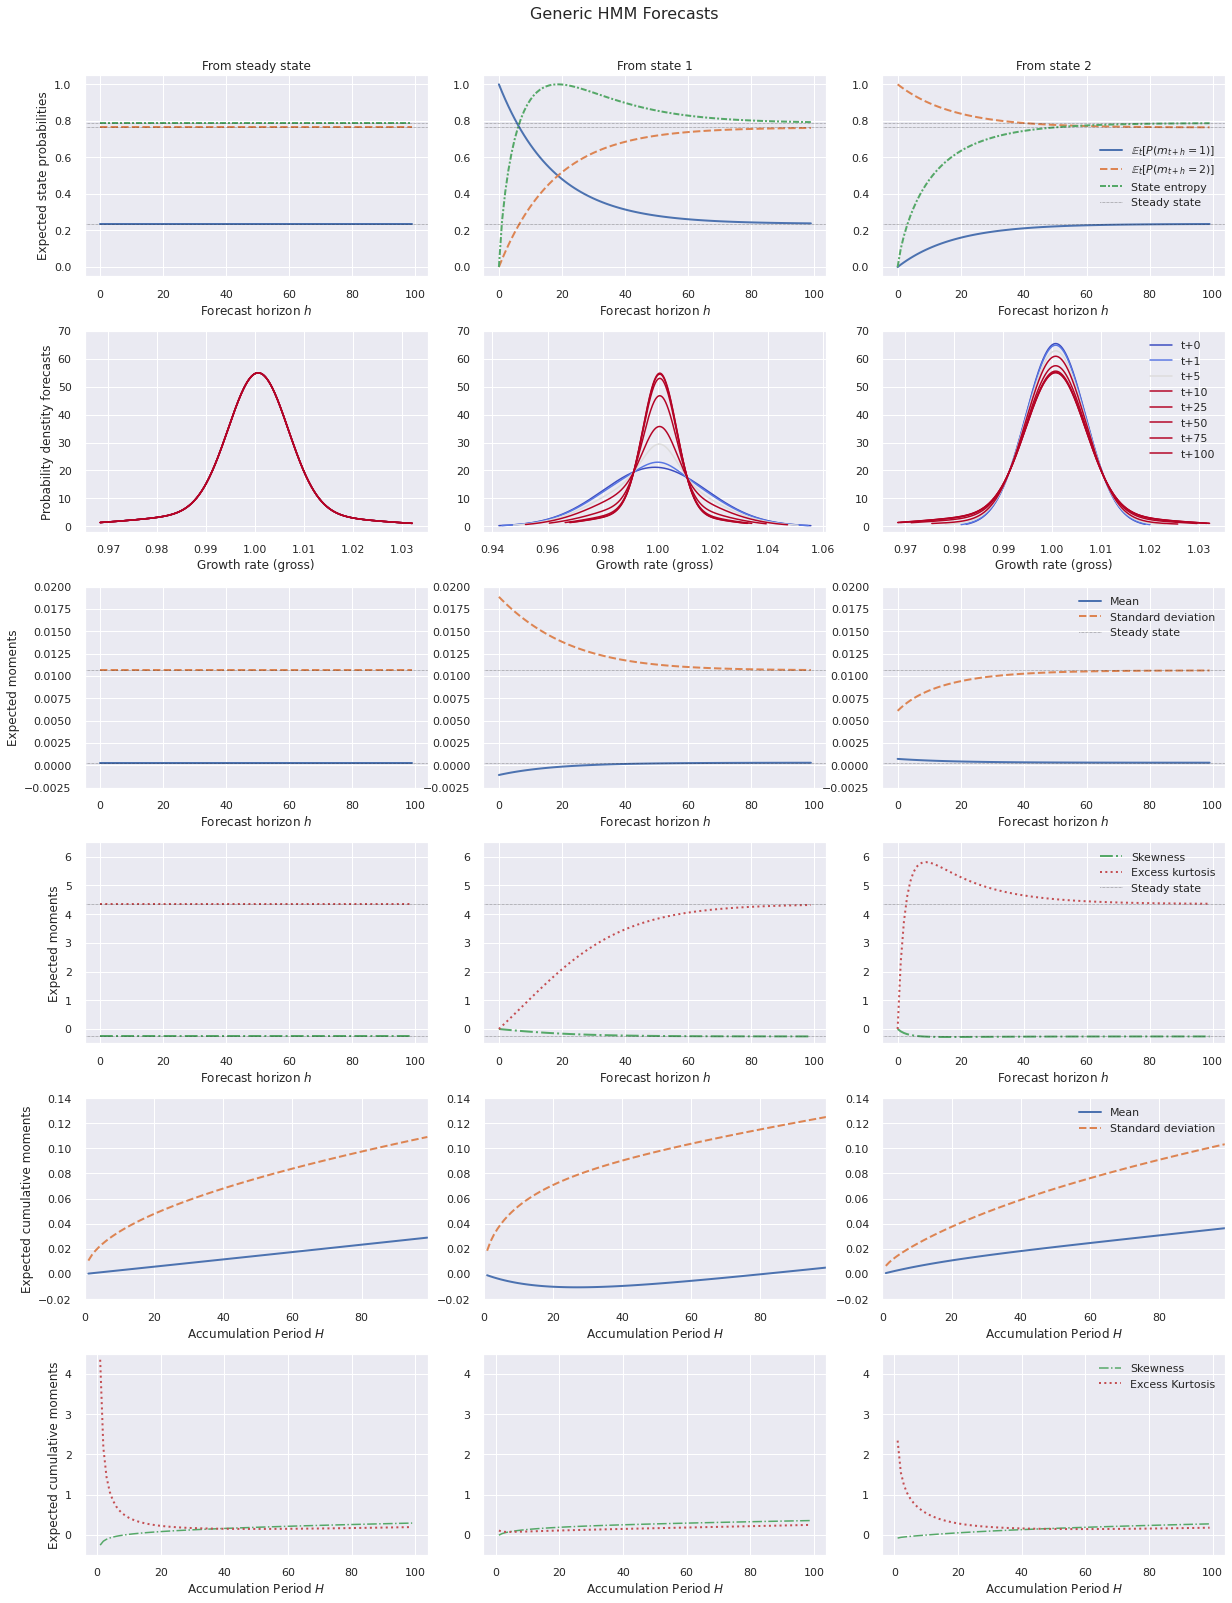

Substituting symbol E from STIXNonUnicode
Substituting symbol E from STIXNonUnicode
Substituting symbol E from STIXNonUnicode
Substituting symbol E from STIXNonUnicode


In [22]:
from src.plots import plot_pdf

fig, axes = plt.subplots(6, 3, figsize=[17,22])
colormap = plt.cm.get_cmap('coolwarm')

i = 0
for hmm in hmms:
    # state variable
    ax = axes[0,i]
    ax.set_ylim([-0.05,1.05])
    ax.plot([hmm.iterate(h).state_vector.squeeze()[0] for h in range(H)], linewidth=2, linestyle='-', label='$\mathbb{E}_t[P(m_{t+h}=1)]$')
    ax.plot([hmm.iterate(h).state_vector.squeeze()[1] for h in range(H)], linewidth=2, linestyle='--', label='$\mathbb{E}_t[P(m_{t+h}=2)]$')
    ax.plot([hmm.iterate(h).entropy() for h in range(H)], linewidth=2, linestyle=(0, (3, 1, 1, 1)), label='State entropy')
    ax.axhline(hmm.steady_state()[0], color='k', linewidth=0.5, linestyle=':', label='Steady state')
    ax.axhline(hmm.steady_state()[1], color='k', linewidth=0.5, linestyle=':')
    ax.axhline(hmm_ss.entropy(), color='k', linewidth=0.5, linestyle=':')
    ax.set_xlabel('Forecast horizon $h$')
    if i == 0:
        ax.set_ylabel('Expected state probabilities')
    if i == 2:
        ax.legend()
    
    # pdfs
    ax = axes[1,i]
    ax.set_ylim([-2, 70])
    for h in pdf_horizons:
        plot_pdf(hmm.iterate(h).distribution, ax=ax, label='t+'+str(h), color=colormap(1/10*h), linewidth=1.5)
        ax.set_xlabel('Growth rate (gross)')
    if i == 0:
        ax.set_ylabel('Probability denstity forecasts')
    if i == 2:
        ax.legend()
    
    # mean & std
    ax = axes[2,i]
    ax.set_ylim([-0.0025, 0.02])
    ax.plot([hmm.iterate(h).mean()-1 for h in range(H)], linewidth=2, linestyle='-', label='Mean')
    ax.plot([hmm.iterate(h).std() for h in range(H)], linewidth=2, linestyle='--', label='Standard deviation')
    ax.axhline(hmm_ss.mean()-1, color='k', linewidth=0.5, linestyle=':', label='Steady state')
    ax.axhline(hmm_ss.std(), color='k', linewidth=0.5, linestyle=':')
    ax.set_xlabel('Forecast horizon $h$')
    if i == 0:
        ax.set_ylabel('Expected moments')
    if i == 2:
        ax.legend()
    
    # skew & kurt
    ax = axes[3,i]
    ax.set_ylim([-0.5, 6.5])
    ax.plot(np.nan)
    ax.plot(np.nan)
    ax.plot([hmm.iterate(h).skew() for h in range(H)], linewidth=2, linestyle='-.', label='Skewness')
    ax.plot([hmm.iterate(h).exkurt() for h in range(H)], linewidth=2, linestyle=':', label='Excess kurtosis')
    ax.axhline(hmm_ss.skew(), color='k', linewidth=0.5, linestyle=':', label='Steady state')
    ax.axhline(hmm_ss.exkurt(), color='k', linewidth=0.5, linestyle=':')
    ax.set_xlabel('Forecast horizon $h$')
    if i == 0:
        ax.set_ylabel('Expected moments')
    if i == 2:
        ax.legend()
    
    # product mean & std
    ax = axes[4,i]
    ax.set_xlim([0-0.1,H-0.9])
    ax.set_ylim([-0.02, 0.14])
    ax.plot([np.nan]+[hmm.product_distribution(h).mean()-1 for h in range(1,H)], linewidth=2, linestyle='-', label='Mean')
    ax.plot([np.nan]+[hmm.product_distribution(h).std() for h in range(1,H)], linewidth=2, linestyle='--', label='Standard deviation')
    ax.set_xlabel('Accumulation Period $H$')
    if i == 0:
        ax.set_ylabel('Expected cumulative moments')
    if i == 2:
        ax.legend()
    
    # product skew & kurt
    ax = axes[5,i]
    #ax.set_xlim([0-0.1,H-0.9])
    ax.set_ylim([-0.5, 4.5])
    ax.plot(np.nan)
    ax.plot(np.nan)
    ax.plot([np.nan]+[hmm.product_distribution(h).skew() for h in range(1,H)], linestyle='-.', label='Skewness')
    ax.plot([np.nan]+[hmm.product_distribution(h).exkurt() for h in range(1,H)], linewidth=2, linestyle=':', label='Excess Kurtosis')
    ax.set_xlabel('Accumulation Period $H$')
    if i == 0:
        ax.set_ylabel('Expected cumulative moments')
    if i == 2:
        ax.legend()

    i += 1
    print(str(i) + '/3 done')


axes[0,0].set_title('From steady state')
axes[0,1].set_title('From state 1')
axes[0,2].set_title('From state 2')

fig.suptitle('Generic HMM Forecasts', y=1.01, fontsize=16)

fig.tight_layout()

plt.show()

fig.savefig('../latex/figures/generic_forecast.pdf', format='pdf', dpi=200, bbox_inches='tight')

## Scratch

In [23]:
emission_models = (ya.NormalModel(mu=1.1, sigma=0.2), ya.NormalModel(mu=1-0.2, sigma=0.3))
transition_matrix = np.matrix([[0.99, 0.01],
                               [0.05, 0.95]])
state_vector = [0.7, 0.3]
hmm = ya.HiddenMarkovModel(emission_models=emission_models, transition_matrix=transition_matrix, state_vector=state_vector)

In [24]:
emission_models = (ya.NormalModel(mu=1, sigma=2), ya.NormalModel(mu=0, sigma=1))
transition_matrix = np.matrix([[0.995, 0.005],
                               [0.01, 0.99]])
state_vector = [0.7, 0.3]
hmm = ya.HiddenMarkovModel(emission_models=emission_models, transition_matrix=transition_matrix, state_vector=state_vector)

In [25]:
mu_0 = -0.001088091030590657
mu_1 = 0.0007135045295192978
sigma2_0 = 0.00035580049937316557
sigma2_1 = 3.712493137298489e-05
sigma_0 = sigma2_0**0.5
sigma_1 = sigma2_1**0.5
emission_models = (ya.NormalModel(mu=mu_0+1, sigma=sigma_0), ya.NormalModel(mu=mu_1+1, sigma=sigma_1))

p00 = 0.9578343472909316
p10 = 0.013033813102422378
transition_matrix = [[p00, 1-p00],
                     [p10, 1-p10]]

state_vector = [0.7, 0.3]
hmm = ya.HiddenMarkovModel(emission_models=emission_models, transition_matrix=transition_matrix, state_vector=state_vector)

In [26]:
Y = hmm.rvs(1000, return_states=True)

<AxesSubplot:>

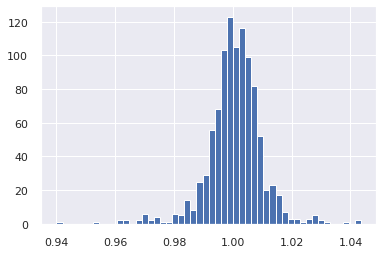

In [27]:
pd.Series(Y[0]).hist(bins=50)

<AxesSubplot:>

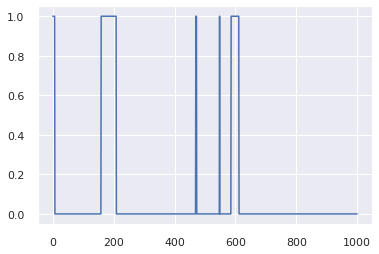

In [108]:
pd.Series(Y[1]).plot()

<AxesSubplot:>

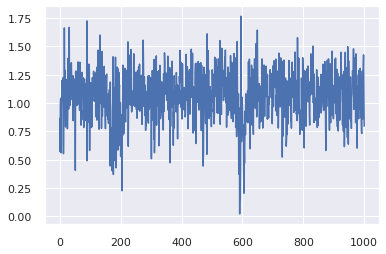

In [109]:
pd.Series(Y[0]).plot()

In [96]:
print(hmm)
hmm.fit(Y[0])
print('\n')
print(hmm)

HiddenMarkovModel(
P=
[[0.99 0.01]
 [0.05 0.95]],
pi=
[[0.7 0.3]],
M=
(NormalDistribution(mu=1.1, sigma=0.2),
NormalDistribution(mu=0.8, sigma=0.3),
))


HiddenMarkovModel(
P=
[[4.62224215e-01 5.37775785e-01]
 [5.14529418e-04 9.99485471e-01]],
pi=
[[9.52923730e-04 9.99047076e-01]],
M=
(NormalDistribution(mu=0.7834, sigma=1.8099),
NormalDistribution(mu=0.7851, sigma=1.8114),
))


In [78]:
_ = hmm.fit(series, return_fit=False)

HiddenMarkovModel(
P=
[[0.99660575 0.00339425]
 [0.04332318 0.95667682]],
pi=
[[0.98645647 0.01354353]],
M=
(NormalDistribution(mu=1.0873, sigma=0.2019),
NormalDistribution(mu=0.8174, sigma=0.3139),
))


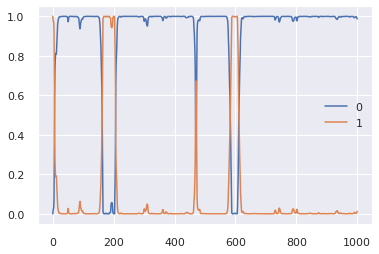

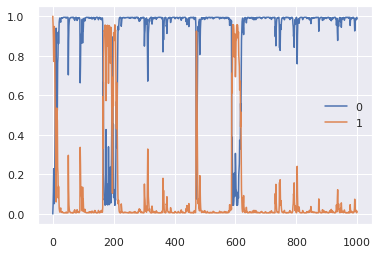

In [111]:
hmm, _ = hmm._estimate_baum_welch(Y[0], return_fit=True)
pd.DataFrame(_['smoothened_probabilities']).plot()
pd.DataFrame(_['filtered_probabilities']).plot()
print(hmm)

HiddenMarkovModel(
P=
[[0.98998744 0.01001256]
 [0.06471389 0.93528611]],
pi=
[[0.38850613 0.61149387]],
M=
(NormalDistribution(mu=0.0094, sigma=0.0395),
NormalDistribution(mu=-0.0123, sigma=0.1061),
))


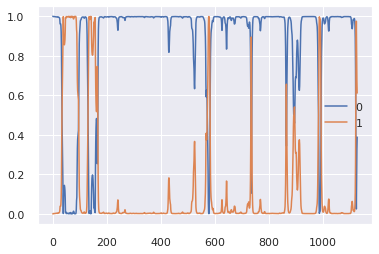

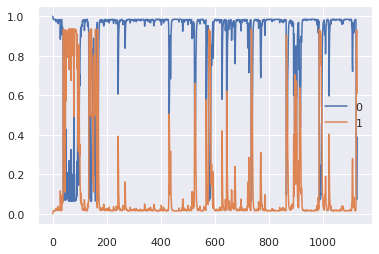

In [105]:
hmm, _ = hmm._estimate_baum_welch(series, return_fit=True)
pd.DataFrame(_['smoothened_probabilities']).plot()
pd.DataFrame(_['filtered_probabilities']).plot()
print(hmm)

In [84]:
hmm.transition_matrix

array([[2.88690909e-03, 9.97113091e-01],
       [2.02994016e-06, 9.99997970e-01]])

In [85]:
hmm.component_means(), hmm.component_stds()

([1.043377319118732, 1.0434607042915003],
 [0.24845345774420757, 0.24834192553218995])

In [86]:
hmm.state_vector

array([[2.03581064e-06, 9.99997964e-01]])

In [87]:
hmm.steady_state()

array([2.03581324e-06, 9.99997964e-01])